Performance Noise Statistics:
count    500.000000
mean       0.005998
std        0.101659
min       -0.292135
25%       -0.065274
50%        0.004220
75%        0.071082
max        0.319311
Name: performance_noise, dtype: float64

Performance Noise Range: -0.2921 to 0.3193

Dataset Overview:
    intern_id  task_completion_time  feedback_rating  attendance_rate  \
0  INTERN_001              6.996321         3.792647         0.674053   
1  INTERN_002             11.605714         3.144385         0.816760   
2  INTERN_003              9.855952         2.238110         0.949178   
3  INTERN_004              8.789268         4.255180         0.892890   
4  INTERN_005              5.248149         3.738925         0.922624   

   performance_noise  performance_score  
0          -0.249941           5.847073  
1           0.229094           3.024038  
2          -0.138957           2.605961  
3          -0.164540           5.338500  
4           0.102257           8.189948  

Dataset Shape: 

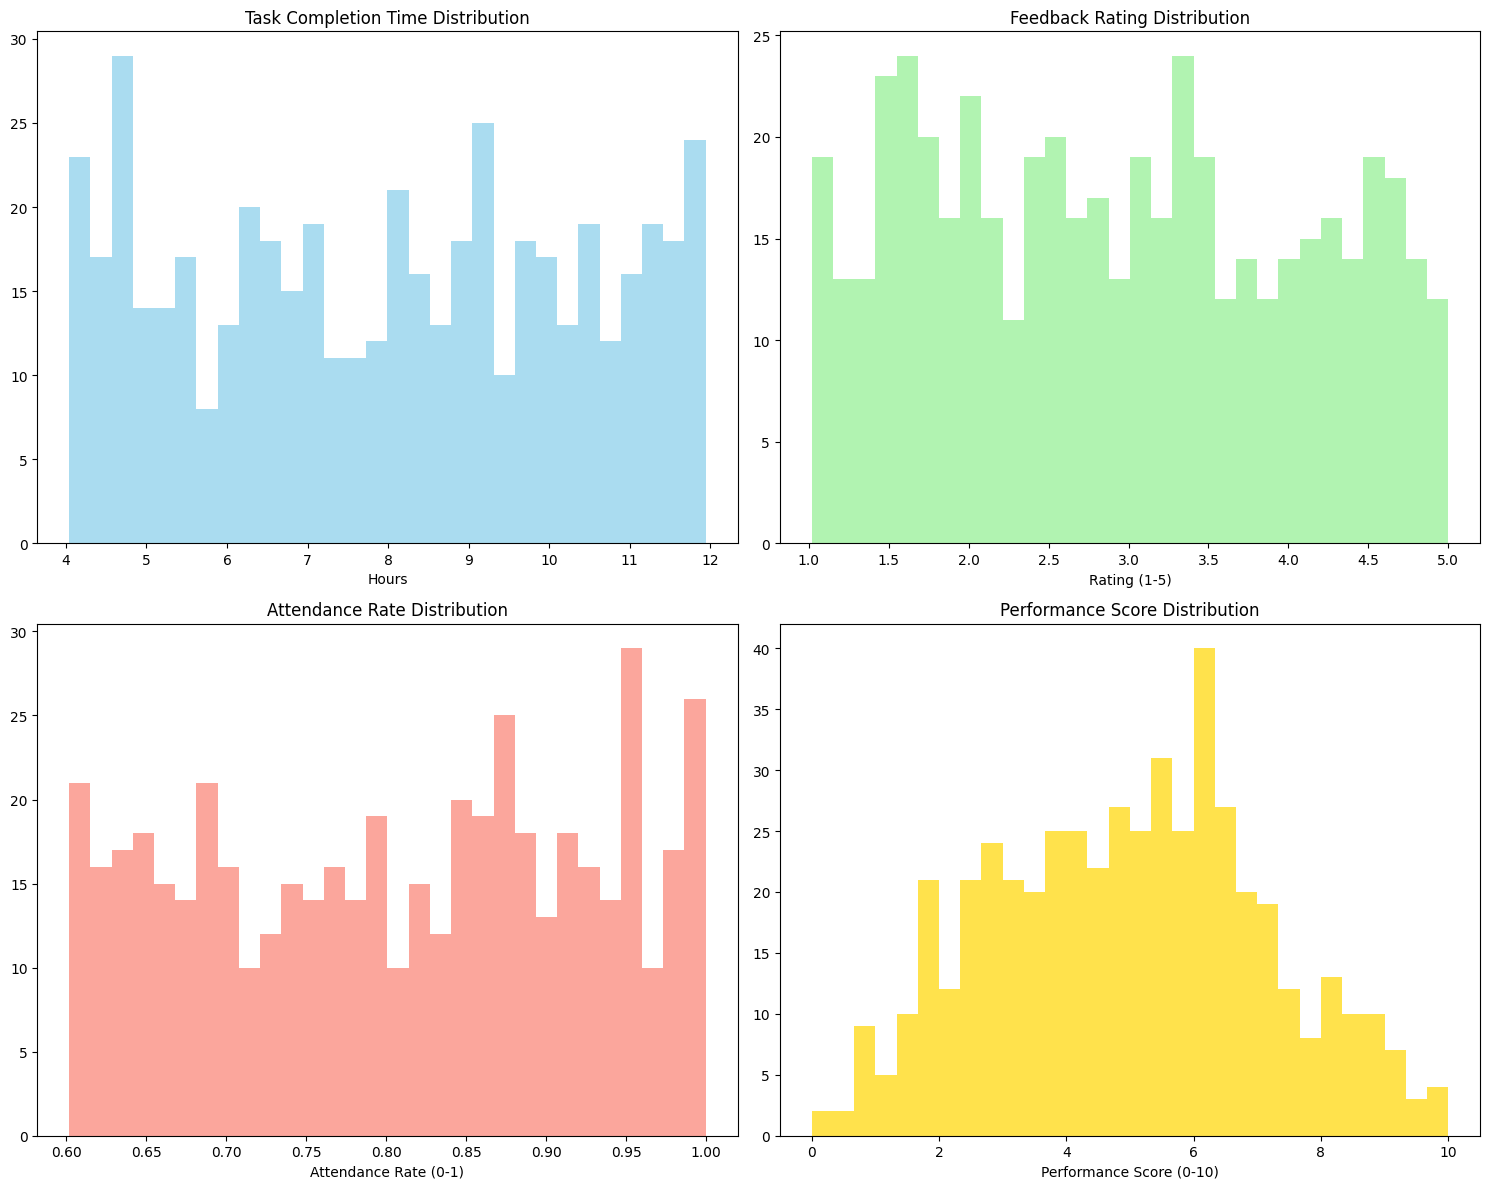

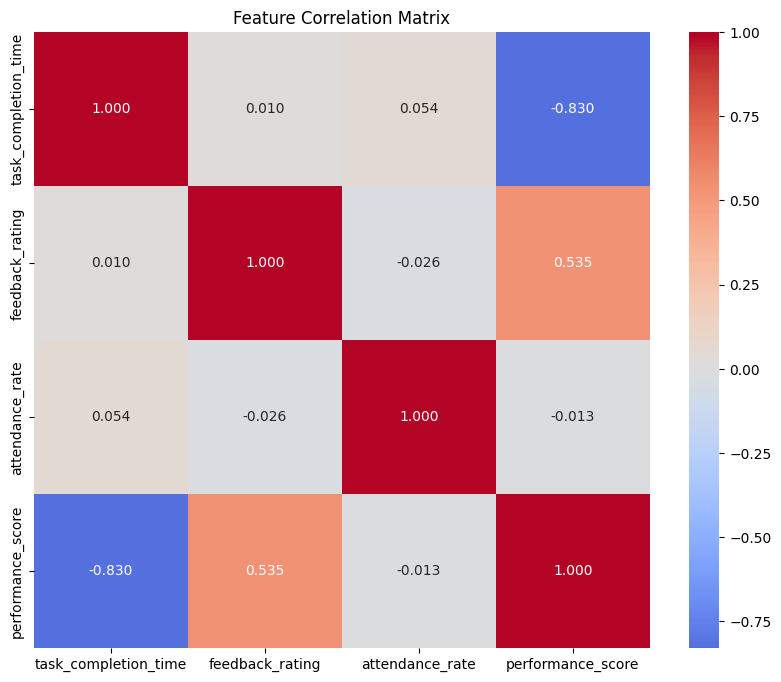


Training set size: 400
Test set size: 100

RANDOM FOREST MODEL
Training MSE: 0.0155
Test MSE: 0.1536
Training MAE: 0.0978
Test MAE: 0.3123
Training R²: 0.9966
Test R²: 0.9648

Feature Importance (Random Forest):
                feature  importance
0  task_completion_time    0.698401
1       feedback_rating    0.294294
2       attendance_rate    0.007305

XGBOOST MODEL
Training MSE: 0.0024
Test MSE: 0.1488
Training MAE: 0.0355
Test MAE: 0.3113
Training R²: 0.9995
Test R²: 0.9659

MODEL COMPARISON
           Model  Test MSE  Test MAE   Test R²
0  Random Forest  0.153625  0.312336  0.964782
1        XGBoost  0.148755  0.311260  0.965898


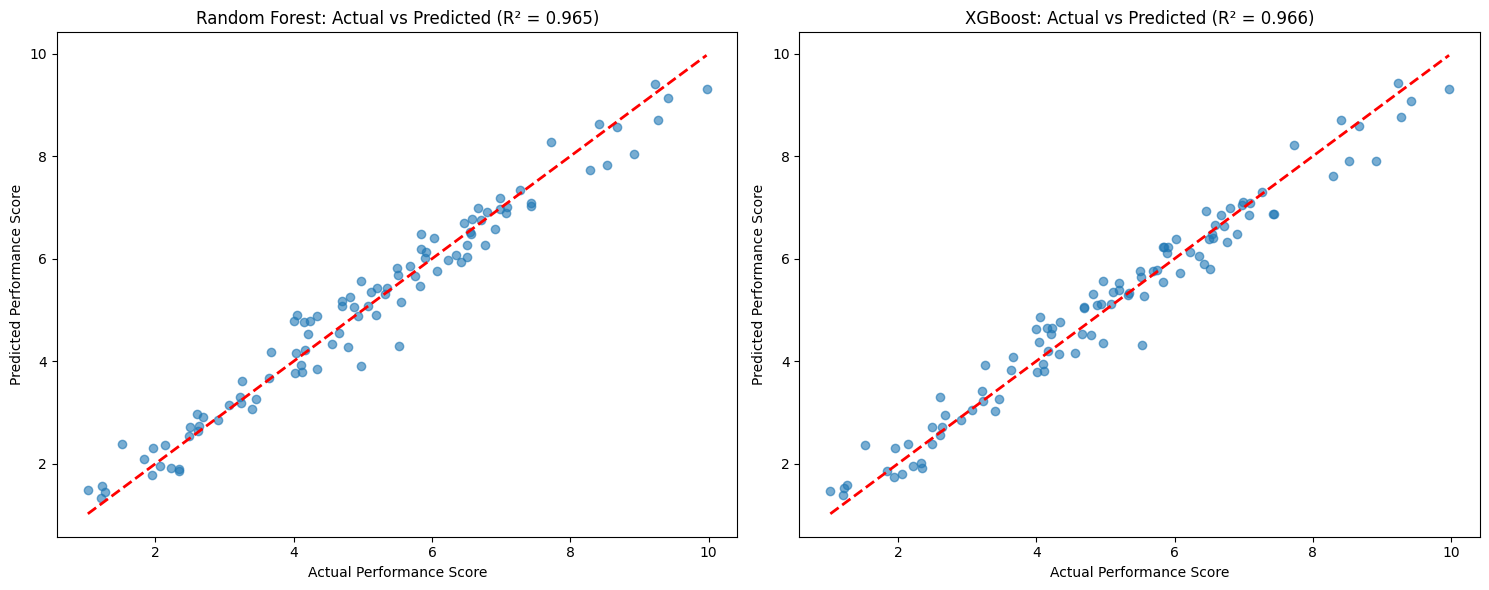


PERFORMANCE CATEGORY ANALYSIS
Actual Performance Distribution:
actual_category
Struggle    50
Good        40
Excel       10
Name: count, dtype: int64

Random Forest Predictions:
rf_predicted_category
Struggle    47
Good        43
Excel       10
Name: count, dtype: int64

XGBoost Predictions:
xgb_predicted_category
Struggle    45
Good        45
Excel       10
Name: count, dtype: int64

SAMPLE PREDICTIONS
     task_completion_time  feedback_rating  attendance_rate  actual_score  \
361                 9.146            2.813            0.684         4.019   
73                 10.524            3.488            0.607         4.103   
374                 4.570            1.102            0.699         5.500   
155                 5.936            1.510            0.901         4.819   
104                11.261            1.483            0.998         1.212   
394                 6.726            3.672            0.735         6.549   
377                 4.186            3.636           

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
n_interns = 500

# Creating synthetic dataset
data = {
    'intern_id': [f'INTERN_{i:03d}' for i in range(1, n_interns + 1)],
    'task_completion_time': np.random.uniform(4, 12, n_interns),  # 4-12 hours
    'feedback_rating': np.random.uniform(1, 5, n_interns),        # 1-5 scale
    'attendance_rate': np.random.uniform(0.6, 1.0, n_interns),   # 60-100%
    'performance_noise': np.random.normal(0, 0.1, n_interns)     # Random noise
}

df = pd.DataFrame(data)


print("Performance Noise Statistics:")
print(df['performance_noise'].describe())
print(f"\nPerformance Noise Range: {df['performance_noise'].min():.4f} to {df['performance_noise'].max():.4f}")


# Lower completion time + higher feedback + higher attendance = better performance
df['performance_score'] = (
    (12 - df['task_completion_time']) * 0.3 +  # (faster = better)
    df['feedback_rating'] * 0.4 +              # Higher feedback = better
    df['attendance_rate'] * 0.3 +              # Higher attendance = better
    df['performance_noise']                     # Add some random variation
)

# Normalization
min_score = df['performance_score'].min()
max_score = df['performance_score'].max()
df['performance_score'] = 10 * (df['performance_score'] - min_score) / (max_score - min_score)

print("\nDataset Overview:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")
print("\nTarget Variable (Performance Score) Statistics:")
print(df['performance_score'].describe())

# Data visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of features
axes[0, 0].hist(df['task_completion_time'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Task Completion Time Distribution')
axes[0, 0].set_xlabel('Hours')

axes[0, 1].hist(df['feedback_rating'], bins=30, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Feedback Rating Distribution')
axes[0, 1].set_xlabel('Rating (1-5)')

axes[1, 0].hist(df['attendance_rate'], bins=30, alpha=0.7, color='salmon')
axes[1, 0].set_title('Attendance Rate Distribution')
axes[1, 0].set_xlabel('Attendance Rate (0-1)')

axes[1, 1].hist(df['performance_score'], bins=30, alpha=0.7, color='gold')
axes[1, 1].set_title('Performance Score Distribution')
axes[1, 1].set_xlabel('Performance Score (0-10)')

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = df[['task_completion_time', 'feedback_rating', 'attendance_rate', 'performance_score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Feature Correlation Matrix')
plt.show()

# Prepare features and target
features = ['task_completion_time', 'feedback_rating', 'attendance_rate']
X = df[features]
y = df['performance_score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Model 1: Random Forest Regressor
print("\n" + "="*50)
print("RANDOM FOREST MODEL")
print("="*50)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)


rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)


rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"Training MSE: {rf_train_mse:.4f}")
print(f"Test MSE: {rf_test_mse:.4f}")
print(f"Training MAE: {rf_train_mae:.4f}")
print(f"Test MAE: {rf_test_mae:.4f}")
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")

# Feature importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(rf_importance)

# Model 2: XGBoost Regressor
print("\n" + "="*50)
print("XGBOOST MODEL")
print("="*50)

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)

xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)


xgb_train_mse = mean_squared_error(y_train, xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, xgb_test_pred)
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print(f"Training MSE: {xgb_train_mse:.4f}")
print(f"Test MSE: {xgb_test_mse:.4f}")
print(f"Training MAE: {xgb_train_mae:.4f}")
print(f"Test MAE: {xgb_test_mae:.4f}")
print(f"Training R²: {xgb_train_r2:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")


print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Test MSE': [rf_test_mse, xgb_test_mse],
    'Test MAE': [rf_test_mae, xgb_test_mae],
    'Test R²': [rf_test_r2, xgb_test_r2]
})

print(comparison)

# Prediction visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest predictions vs actual
axes[0].scatter(y_test, rf_test_pred, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Performance Score')
axes[0].set_ylabel('Predicted Performance Score')
axes[0].set_title(f'Random Forest: Actual vs Predicted (R² = {rf_test_r2:.3f})')

# XGBoost predictions vs actual
axes[1].scatter(y_test, xgb_test_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Performance Score')
axes[1].set_ylabel('Predicted Performance Score')
axes[1].set_title(f'XGBoost: Actual vs Predicted (R² = {xgb_test_r2:.3f})')

plt.tight_layout()
plt.show()

# Classify interns as Excel/Good/Struggle based on performance score
def classify_performance(score):
    if score >= 7.5:
        return 'Excel'
    elif score >= 5.0:
        return 'Good'
    else:
        return 'Struggle'

# Add classifications to test set
test_results = X_test.copy()
test_results['actual_score'] = y_test
test_results['rf_predicted_score'] = rf_test_pred
test_results['xgb_predicted_score'] = xgb_test_pred
test_results['actual_category'] = test_results['actual_score'].apply(classify_performance)
test_results['rf_predicted_category'] = test_results['rf_predicted_score'].apply(classify_performance)
test_results['xgb_predicted_category'] = test_results['xgb_predicted_score'].apply(classify_performance)


print("\n" + "="*50)
print("PERFORMANCE CATEGORY ANALYSIS")
print("="*50)

print("Actual Performance Distribution:")
print(test_results['actual_category'].value_counts())

print("\nRandom Forest Predictions:")
print(test_results['rf_predicted_category'].value_counts())

print("\nXGBoost Predictions:")
print(test_results['xgb_predicted_category'].value_counts())


print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

sample_results = test_results.head(10)[['task_completion_time', 'feedback_rating', 'attendance_rate',
                                       'actual_score', 'rf_predicted_score', 'xgb_predicted_score',
                                       'actual_category', 'rf_predicted_category', 'xgb_predicted_category']]

print(sample_results.round(3))

print("\n" + "="*50)
print("RECOMMENDATIONS")
print("="*50)

